<a href="https://colab.research.google.com/github/MrCharli03/RL_BFRRCE/blob/main/notebook2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Esteban Becerra, Carlos Cruzado, Anastasiya Ruzhytska
Email: esteban.becerraf@um.es carlos.cruzadoe1@um.es anastasiya.r.r@um.es
Date: 2025/02/23

# **Monte Carlo con Políticas epsilon-soft**

_Esto es un ejemplo de uso de Gymnasium e informe sobre un experimento de aprendizaje por refuerzo_

````
Luis D. Hernández.
<ldaniel at um.es>
````

Este notebook describe un experimento de aprendizaje por refuerzo utilizando el algoritmo de Monte Carlo con políticas epsilon-soft. El propósito de este análisis es entrenar un agente en un entorno de gym con el juego "FrozenLake", un entorno estándar en el que el agente debe aprender a moverse a través de un mapa en busca de una meta, evitando caer en agujeros. A continuación, se presenta una descripción de las diferentes partes del código y el proceso utilizado en el experimento.

## **1. Preparación del Entorno**

La preparación consta de las siguientes partes:
- **Instalación de Dependencias**: Se instalan las librerías necesarias para utilizar el entorno `gymnasium` para la simulación, con el objetivo de crear un ambiente controlado para que el agente pueda interactuar.
- **Importación de Librerías**: Se importan las bibliotecas necesarias como `numpy` para el manejo de matrices y `matplotlib` para la visualización de los resultados.

- **Importación del Entorno "FrozenLake"**:
Se cargan dos versiones del entorno "FrozenLake": una de 4x4 y otra de 8x8. Ambas versiones no son resbaladizas, lo que facilita la comprensión de los resultados, dado que el entorno resbaladizo podría dificultar la comprensión inicial del aprendizaje.

#### 3. **Funciones para Mostrar los Resultados**
   - Se define una función para graficar la proporción de recompensas obtenidas en cada episodio del entrenamiento. Esto ayuda a visualizar el progreso del agente en términos de su desempeño durante el entrenamiento.



##### _________ **Código de la Instalación e Importación**
----

In [1]:
%%capture
#@title Instalamos gym
!pip install 'gym[box2d]==0.20.0'

## Instalación de algunos paquetes.
#!apt-get update
## Para usar gymnasium[box2d]
#!apt install swig
#!pip install gymnasium[box2d]

In [2]:
#@title Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym

In [3]:
#@title Importamos el lago helado
name = 'FrozenLake-v1'
env4 = gym.make(name, is_slippery=False, map_name="4x4", render_mode="ansi") # No resbaladizo para entender mejor los resultados.
env8 = gym.make(name, is_slippery=False, map_name="8x8", render_mode="ansi") # No resbaladizo para entender mejor los resultados.

## **2. Diseño del Agente**

El diseño del agente consta de dos partes, el algoritmo con el que aprende y las políticas (toma de decisiones) que realiza.

- **Políticas del Agente**
   - **Política epsilon-soft**: Se define una política donde todas las acciones tienen una probabilidad de ser elegida.
   - **Política epsilon-greedy**: basada en la política epsilon-soft. De esta forma el agente tiene una pequeña probabilidad de explorar (tomar una acción aleatoria) y una mayor probabilidad de explotar (tomar la acción que considera mejor). Esto permite equilibrar la exploración y la explotación.
   - **Política greedy**: Es la usada una vez que "ha aprendido".

- **Algoritmo de Iteración de Valor**
  - Se implementa el algoritmo de iteración de valor utilizando Monte Carlo.
  - Se usa una versión "on-policy" de Monte Carlo con políticas epsilon greedy sobre una política epsilon-soft.
  - Se basa en el criterio de todas las visitas.
  - Otro aspecto es que la actualización de los retornos no se realiza en el orden inverso a las visitas.

#### **Código de las políticas y algoritmo MC**
----------------

In [4]:
# @title Políticas del agente

# actions
LEFT, DOWN, RIGHT, UP = 0,1,2,3

# Política epsilon-soft. Se usa para el entrenamiento
def random_epsilon_greedy_policy(Q, epsilon, state, nA):
    pi_A = np.ones(nA, dtype=float) * epsilon / nA
    best_action = np.argmax(Q[state])
    pi_A[best_action] += (1.0 - epsilon)
    return pi_A

# Política epsilon-greedy a partir de una epsilon-soft
def epsilon_greedy_policy(Q, epsilon, state, nA):
    pi_A = random_epsilon_greedy_policy(Q, epsilon, state, nA)
    return np.random.choice(np.arange(nA), p=pi_A)

# Política Greedy a partir de los valones Q. Se usa para mostrar la solución.
def pi_star_from_Q(env, Q):
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset() # start in top-left, = 0
    actions = ""
    while not done:
        action = np.argmax(Q[state, :])
        actions += f"{action}, "
        pi_star[state,action] = action
        state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    return pi_star, actions

In [5]:
#@title Algoritmo de Iteración de Valor versión MC con Políticas epsilon-soft

def on_policy_all_visit(env, num_episodes=5000, epsilon=0.4, decay=False, discount_factor=1):
    """
    Implementación auténtica de Monte Carlo de todas las visitas:
    Para cada episodio, se calcula el retorno Gₜ desde cada instante t hasta el final del episodio
    y se actualiza Q(s, a) de forma incremental.
    """
    nA = env.action_space.n
    Q = np.zeros([env.observation_space.n, nA])
    n_visits = np.zeros([env.observation_space.n, nA])

    stats = 0.0
    list_stats = []       # Para almacenar la recompensa promedio
    episode_lengths = []  # Para almacenar la longitud de cada episodio
    step_display = num_episodes / 10 if num_episodes >= 10 else 1

    for t in tqdm(range(num_episodes)):
        state, info = env.reset(seed=100)
        done = False
        episode = []  # Almacenará (estado, acción, recompensa) en cada paso

        # Generamos el episodio completo
        while not done:
            if decay:
                epsilon = min(1.0, 1000.0/(t+1))
            action = epsilon_greedy_policy(Q, epsilon, state, nA)
            new_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            episode.append((state, action, reward))
            state = new_state

        # Calculamos el retorno G para cada paso del episodio.
        # Se utiliza una forma recursiva recorriendo el episodio en orden inverso.
        G = 0.0
        returns = [0] * len(episode)  # returns[i] será el retorno desde el paso i
        for i in reversed(range(len(episode))):
            s, a, r = episode[i]
            G = r + discount_factor * G
            returns[i] = G

        # Actualizamos Q para cada visita (every-visit MC)
        for i, (s, a, _) in enumerate(episode):
            n_visits[s, a] += 1.0
            alpha = 1.0 / n_visits[s, a]
            Q[s, a] += alpha * (returns[i] - Q[s, a])

        # Para estadísticas, consideramos el retorno desde el primer paso del episodio
        stats += returns[0]
        promedio_recompensas = stats / (t + 1)
        list_stats.append(promedio_recompensas)
        episode_lengths.append(len(episode))

        if (t+1) % step_display == 0 and t != 0:
            print(f"Episodio {t+1}/{num_episodes} -> Éxito promedio: {promedio_recompensas:.3f}, epsilon: {epsilon:.3f}")

    return Q, list_stats, episode_lengths



**Cambios Realizados:**

- **Almacenamiento en el episodio:**  
  - Se guarda cada paso como una tupla de *(estado, acción, recompensa)* en lugar de solo *(estado, acción)*.

- **Cálculo del retorno:**  
  - Se recorre el episodio en orden inverso para calcular, de forma individual, el retorno \(G_t\) para cada paso, almacenándolo en un vector `returns`.  

- **Actualización de Q:**  
  - Se actualiza \(Q(s, a)\) utilizando el retorno específico de cada visita (tomado de `returns[i]`), en lugar de usar el mismo valor global para todas las visitas.

- **Estadísticas:**  
  - Se registra además la longitud de cada episodio en `episode_lengths`.  
  - Se inicializa `list_stats` como lista vacía y se actualiza con el promedio de \(G_0\) (retorno del primer paso) de cada episodio, en lugar de iniciar con `[stats]` y acumular el retorno global.

- **Salida por pantalla:**  
  - Se muestra un mensaje detallado indicando el número de episodio, el éxito promedio y el valor de epsilon, en contraste con el mensaje más simplificado del original.

## **3. Experimentación**

   - En esta sección, el algoritmo de Monte Carlo con la política epsilon-soft se ejecuta tanto para el entorno de 4x4 como al de 8x8 de FrozenLake sin resbalar.
   
   - En ambos casos se realiza un entrenamiento con un número determinado de episodios (5000 en concreto)

   - Además en el escenario 8x8 el  epsilon tiene decaimiento de acuerdo a la expresión: $\epsilon = min(1.0, 1000.0/(t+1))$

   - Durante el entrenamiento hay una visualización de la proporción de recompensas obtenidas a lo largo del entrenamiento.

   - Junto a dicho volcado se muestra gráficamente la proporcion de recompensas obtendias.

   - También se hace un volcado de los valores Q de cada estado, donde se muestra cómo el agente valora diferentes acciones en distintos estados del entorno, lo que puede interpretarse como su conocimiento sobre las mejores estrategias para alcanzar la meta sin caer en los agujeros.

   - Además, se muestra la política óptima derivada de los valores Q. Esta política es la que el agente seguiría si tuviera que elegir siempre la acción que maximiza su recompensa esperada.

   

### **3.1 Repressentaciones Gráficas**

Para comprobar el aprendizaje se mostrará la función $f(t)=\frac{\sum_{i=1}^t R_i}{t}$ para $t=1,2,\ldots, NumeroEpisodios$. La justificación es la siguiente. Como sabemmos que el retorno en el estados inicial 1 (pues no hay descuento) o 9, si se divide por el número de episodios ejecutados se calcular el porcentaje de recompensas positivas obtenidas. Dicho de otra forma, nos dirá el porcentaje de veces que el agente ha llegado al estado terminal.


In [6]:
# @title Funciones para mostrar los resultados

def plot(list_stats):
  # Creamos una lista de índices para el eje x
  indices = list(range(len(list_stats)))

  # Creamos el gráfico
  plt.figure(figsize=(6, 3))
  plt.plot(indices, list_stats)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

# Define la función para mostrar el tamaño de los episodios
# Pon aquí tu código.

Gráfica que muestre la longitud de los episodios en cada estado

In [7]:
def plot_episode_lengths(episode_lengths):
    """
    Muestra la longitud de cada episodio a lo largo del entrenamiento.
    """
    plt.figure(figsize=(6, 3))
    plt.plot(episode_lengths, label="Longitud del episodio")
    plt.xlabel("Episodio")
    plt.ylabel("Longitud")
    plt.title("Evolución de la longitud de los episodios")
    plt.grid(True)
    plt.legend()
    plt.show()


 Gráfica que muestre el escenario

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_policy_on_grid(Q, grid_size=(4,4)):
    """
    Plotea la política óptima en una cuadrícula.

    Parámetros:
    - Q: matriz Q donde cada fila corresponde a un estado y cada columna a una acción.
         Se asume que la acción óptima en cada estado es la de mayor valor.
    - grid_size: tupla (filas, columnas) que indica el tamaño de la cuadrícula.
    """
    # Mapear cada acción a una flecha: 0: izquierda, 1: abajo, 2: derecha, 3: arriba
    arrow_dict = {0: r'$\leftarrow$',
                  1: r'$\downarrow$',
                  2: r'$\rightarrow$',
                  3: r'$\uparrow$'}

    n_states = Q.shape[0]
    optimal_policy = [np.argmax(Q[s]) for s in range(n_states)]

    rows, cols = grid_size
    fig, ax = plt.subplots(figsize=(cols, rows))

    # Dibujar líneas de la cuadrícula
    for x in range(cols + 1):
        ax.axvline(x, color='black')
    for y in range(rows + 1):
        ax.axhline(y, color='black')

    # Colocar la flecha en cada celda
    for state, action in enumerate(optimal_policy):
        # Convertir el número de estado a coordenadas (fila, columna)
        row = state // cols
        col = state % cols
        # Ajustar para que la fila 0 aparezca en la parte superior
        ax.text(col + 0.5, rows - row - 0.5, arrow_dict.get(action, ''),
                ha='center', va='center', fontsize=20)

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_xticks(np.arange(0, cols + 1))
    ax.set_yticks(np.arange(0, rows + 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.title("Política Óptima en FrozenLake")
    plt.show()

# Ejemplo de uso:
# Supongamos que 'Q' es la matriz de valores obtenida tras el entrenamiento en FrozenLake 4x4
# plot_policy_on_grid(Q, grid_size=(4,4))


### **3.2 Experimentación en el escenario 4x4**



   - Se realizan 5000 epsisodios y se actualizan los valores Q (valor de acción) basándose en las recompensas obtenidas durante cada episodio completo (e.d. aplicamos Monte Carlo) Se apica una política $\epsilon$ greedy sobre una política $\epsilon$ soft con un valor $\epsilon$ constante




In [9]:
# @title Aprendizaje
Q, list_stats, episode_lengths = on_policy_all_visit(env4, num_episodes=50000, epsilon=0.4, discount_factor=1)

 10%|█         | 5105/50000 [00:09<01:26, 520.52it/s]

Episodio 5000/50000 -> Éxito promedio: 0.326, epsilon: 0.400


 20%|██        | 10126/50000 [00:14<01:02, 642.02it/s]

Episodio 10000/50000 -> Éxito promedio: 0.427, epsilon: 0.400


 31%|███       | 15365/50000 [00:18<00:17, 1937.20it/s]

Episodio 15000/50000 -> Éxito promedio: 0.465, epsilon: 0.400


 41%|████      | 20251/50000 [00:22<00:26, 1117.49it/s]

Episodio 20000/50000 -> Éxito promedio: 0.482, epsilon: 0.400


 50%|█████     | 25101/50000 [00:26<00:26, 949.09it/s] 

Episodio 25000/50000 -> Éxito promedio: 0.491, epsilon: 0.400


 61%|██████    | 30338/50000 [00:29<00:10, 1890.63it/s]

Episodio 30000/50000 -> Éxito promedio: 0.496, epsilon: 0.400


 71%|███████   | 35302/50000 [00:31<00:07, 1898.82it/s]

Episodio 35000/50000 -> Éxito promedio: 0.501, epsilon: 0.400


 80%|████████  | 40176/50000 [00:34<00:07, 1384.77it/s]

Episodio 40000/50000 -> Éxito promedio: 0.504, epsilon: 0.400


 91%|█████████ | 45300/50000 [00:37<00:02, 1921.32it/s]

Episodio 45000/50000 -> Éxito promedio: 0.508, epsilon: 0.400


100%|██████████| 50000/50000 [00:40<00:00, 1237.71it/s]

Episodio 50000/50000 -> Éxito promedio: 0.510, epsilon: 0.400


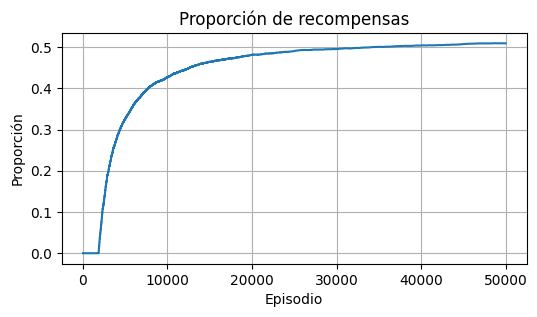

Máxima proporcion: 0.50952


In [10]:
#@title Proporción de aciertos por número de episodios

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

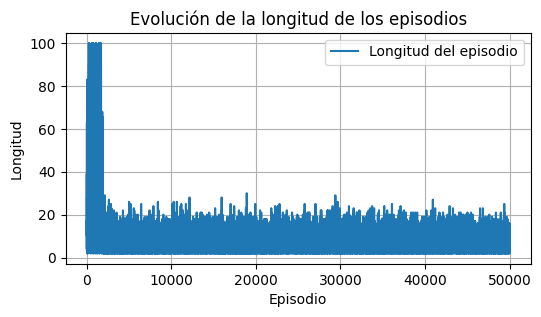

In [11]:
# Gráfica de la longitud de los episodios
plot_episode_lengths(episode_lengths)

####.
Mostramos los valores Q para cada estado. Cada estado tienen 4 valores, que se corresponden con las 4 acciones que se pueden en cada estado.

In [12]:
# @title Tabla de valores Q
LEFT, DOWN, RIGHT, UP = 0,1,2,3
print("Valores Q para cada estado:\n", Q)


Valores Q para cada estado:
 [[0.15100713 0.39509478 0.4997438  0.38182589]
 [0.37627737 0.         0.59892312 0.50039339]
 [0.50008377 0.62329594 0.52961083 0.60083814]
 [0.60413048 0.         0.52567568 0.52309783]
 [0.06080722 0.52404332 0.         0.25561497]
 [0.         0.         0.         0.        ]
 [0.         0.80624405 0.         0.58552478]
 [0.         0.         0.         0.        ]
 [0.12774194 0.         0.65466392 0.33095804]
 [0.44113372 0.8183613  0.76052385 0.        ]
 [0.71340782 0.95935193 0.         0.63846368]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.82570281 0.9572321  0.72179813]
 [0.82404372 0.95390071 1.         0.80297085]
 [0.         0.         0.         0.        ]]


- También se muestra la política óptima (greedy) obtenida a partir del aprendizaje anterior.

- Cada estado tienen 4 valores, pero todos son 0 menos 1. Es decir, en cada estado se aplica de manera determinística una única acción.

*TODO:* Mostrar de forma gráfica el escenario.

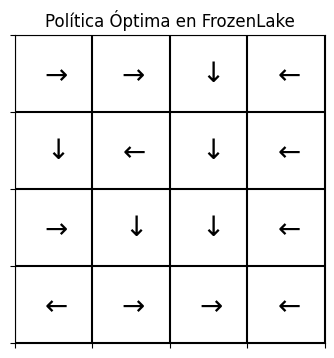

In [13]:
plot_policy_on_grid(Q, grid_size=(4,4))

In [14]:
# @title Política final
LEFT, DOWN, RIGHT, UP = 0,1,2,3
pi, actions = pi_star_from_Q(env4, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env4.render())
print()

Política óptima obtenida
 [[0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 0. 0. 0.]] 
 Acciones 2, 2, 1, 1, 1, 2,  
 Para el siguiente grid
   (Right)
SFFF
FHFH
FFFH
HFFG




# Simulacion Video


In [15]:
# Instalación de algunos paquetes.
!apt-get update

# Para visualizar en colab https://medium.com/@coldstart_coder/visually-rendering-python-gymnasium-in-jupyter-notebooks-4413e4087a0f
!apt-get install -y python-opengl ffmpeg
!apt-get install --upgrade cmake

# Para usar gymnasium[box2d]
!apt install swig xvfb
!pip install -U  pyvirtualdisplay

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

FUNCIONES PARA MOSTRAR VIDEOS

In [16]:
def get_latest_episode_video_file(directory):
    """
    Devuelve el nombre (con ruta) del video .mp4 de episodio
    más reciente en 'directory', siguiendo el patrón
    'rl-video-episode-<numero>.mp4'.
    """
    pattern = re.compile(r"rl-video-episode-(\d+)\.mp4")
    latest_file = None
    highest_episode = -1
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            episode_number = int(match.group(1))
            if episode_number > highest_episode:
                highest_episode = episode_number
                latest_file = os.path.join(directory, filename)
    return latest_file

def embed_video(video_file):
    """
    Incrusta el video .mp4 en el notebook a partir de su ruta.
    """
    video_data = io.open(video_file, 'r+b').read()
    encoded_data = base64.b64encode(video_data)
    display.display(HTML(data=f'''
        <video alt="test" autoplay loop controls style="height: 400px;">
        <source src="data:video/mp4;base64,{encoded_data.decode('ascii')}" type="video/mp4" />
        </video>'''))


FUNCIÓN PARA GRABAR EPISODIOS

In [17]:
def record_policy_in_frozenlake(Q, map_name="4x4", episodes=3, video_folder="videos", is_slippery=False):
    """
    - Crea un entorno FrozenLake con render_mode="rgb_array" para poder capturar video.
    - Envuelve el entorno con RecordVideo, grabando cada episodio.
    - Ejecuta 'episodes' episodios usando la política GREEDY a partir de Q.
    - Cierra el entorno y retorna la carpeta con los videos generados.
    """
    os.makedirs(video_folder, exist_ok=True)  # Crear carpeta de videos si no existe

    # 1. Creamos el entorno con "rgb_array" para poder grabar.
    env = gym.make("FrozenLake-v1", map_name=map_name, is_slippery=is_slippery, render_mode="rgb_array")

    # 2. Envolvemos el entorno con RecordVideo
    #    - Graba todos los episodios con episode_trigger=lambda e: True
    env = gym.wrappers.RecordVideo(
        env,
        video_folder=video_folder,
        episode_trigger=lambda e: True
    )

    # 3. Ejecutamos varios episodios usando la política GREEDY de Q
    for ep in range(episodes):
        state, info = env.reset()
        done = False
        truncated = False
        while not (done or truncated):
            # Elige la acción GREEDY
            action = np.argmax(Q[state])
            state, reward, done, truncated, info = env.step(action)
            env.render()  # Para que se capturen los fotogramas
    env.close()
    return video_folder

In [18]:
import os
import re
import io
import base64

import numpy as np
import gymnasium as gym
from IPython import display # This import is kept
from IPython.display import HTML

from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900)) # Changed 'display' to 'virtual_display'
virtual_display.start()

video_dir_4x4 = record_policy_in_frozenlake(Q, map_name="4x4", episodes=2, video_folder="videos4x4", is_slippery=False)

# Mostramos el último video generado
latest_file_4x4 = get_latest_episode_video_file(video_dir_4x4)
print("Último video 4x4:", latest_file_4x4)
display.display(HTML(data=f'''  # Use 'display' from 'IPython.display'
    <video alt="test" autoplay loop controls style="height: 400px;">
    <source src="data:video/mp4;base64,{base64.b64encode(io.open(latest_file_4x4, 'r+b').read()).decode('ascii')}" type="video/mp4" />
    </video>''')) # Embed video data within HTML

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos4x4 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Último video 4x4: videos4x4/rl-video-episode-1.mp4


### **3.3 Experimentación en el escenario 8x8**

  - Se realizan 5000 epsisodios y se actualizan los valores Q (valor de acción) basándose en las recompensas obtenidas durante cada episodio completo (e.d. aplicamos Monte Carlo) Se apica una política $\epsilon$ greedy sobre una política $\epsilon$ soft con un valor $\epsilon$ decreciente



In [19]:
# @title Aprendizaje
Q, list_stats, episode_lengths = on_policy_all_visit(env8, num_episodes=50000, epsilon=0.4, decay=True, discount_factor=1)

 10%|█         | 5095/50000 [00:15<01:23, 537.69it/s]

Episodio 5000/50000 -> Éxito promedio: 0.506, epsilon: 0.200


 20%|██        | 10172/50000 [00:21<00:41, 967.25it/s]

Episodio 10000/50000 -> Éxito promedio: 0.712, epsilon: 0.100


 30%|███       | 15185/50000 [00:27<00:37, 934.24it/s]

Episodio 15000/50000 -> Éxito promedio: 0.792, epsilon: 0.067


 40%|████      | 20135/50000 [00:33<00:29, 1000.82it/s]

Episodio 20000/50000 -> Éxito promedio: 0.837, epsilon: 0.050


 50%|█████     | 25110/50000 [00:38<00:30, 821.38it/s]

Episodio 25000/50000 -> Éxito promedio: 0.865, epsilon: 0.040


 60%|██████    | 30178/50000 [00:44<00:21, 924.50it/s]

Episodio 30000/50000 -> Éxito promedio: 0.884, epsilon: 0.033


 70%|███████   | 35191/50000 [00:50<00:15, 940.45it/s]

Episodio 35000/50000 -> Éxito promedio: 0.898, epsilon: 0.029


 80%|████████  | 40189/50000 [00:56<00:10, 940.39it/s]

Episodio 40000/50000 -> Éxito promedio: 0.909, epsilon: 0.025


 90%|█████████ | 45109/50000 [01:01<00:05, 967.48it/s]

Episodio 45000/50000 -> Éxito promedio: 0.918, epsilon: 0.022


100%|██████████| 50000/50000 [01:06<00:00, 747.86it/s]

Episodio 50000/50000 -> Éxito promedio: 0.925, epsilon: 0.020


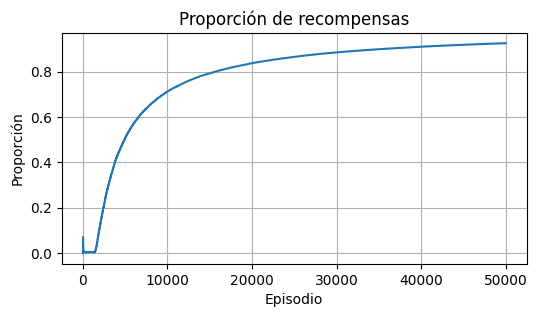

Máxima proporcion: 0.92496


In [20]:
#@title Proporción de aciertos por número de episodios

plot(list_stats)
print(f"Máxima proporcion: {list_stats[-1]}")

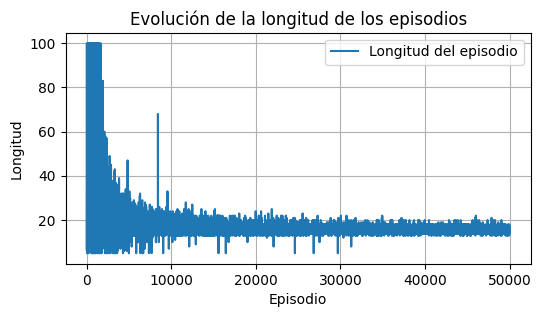

In [21]:
# Gráfica de la longitud de los episodios
plot_episode_lengths(episode_lengths)

####.
Mostramos los valores Q para cada estado. Cada estado tienen 4 valores, que se corresponden con las 4 acciones que se pueden en cada estado.

In [22]:
# @title Tabla de valores Q
LEFT, DOWN, RIGHT, UP = 0,1,2,3
print("Valores Q para cada estado:\n", Q)

Valores Q para cada estado:
 [[0.31318877 0.32338654 0.91319684 0.30065812]
 [0.38722716 0.40008558 0.92864169 0.37640667]
 [0.51783841 0.49540758 0.93545828 0.53723707]
 [0.59399478 0.57032258 0.94074825 0.59170447]
 [0.64687101 0.6383581  0.94473502 0.66928011]
 [0.71026616 0.94907033 0.70893142 0.69025157]
 [0.32075472 0.29277567 0.79219463 0.30620155]
 [0.34220532 0.79162656 0.35       0.36727273]
 [0.0552     0.0532491  0.41994511 0.05877269]
 [0.10912907 0.07699115 0.09333333 0.59049849]
 [0.08950086 0.10534591 0.09302326 0.52810304]
 [0.15885417 0.         0.1372093  0.66569767]
 [0.27380952 0.19459459 0.2539185  0.75365141]
 [0.71803853 0.70588235 0.95389781 0.74375   ]
 [0.74697674 0.95679427 0.74445516 0.75813008]
 [0.48615385 0.84563758 0.40159574 0.46486486]
 [0.02605863 0.02184087 0.08798017 0.01461039]
 [0.03900709 0.03287197 0.02030457 0.15042373]
 [0.02446483 0.02095808 0.         0.14072495]
 [0.         0.         0.         0.        ]
 [0.         0.04444444 0.39795

- También se muestra la política óptima (greedy) obtenida a partir del aprendizaje anterior.

- Cada estado tienen 4 valores, pero todos son 0 menos 1. Es decir, en cada estado se aplica de manera determinística una única acción.

*TODO:* Mostrar de forma gráfica el escenario.

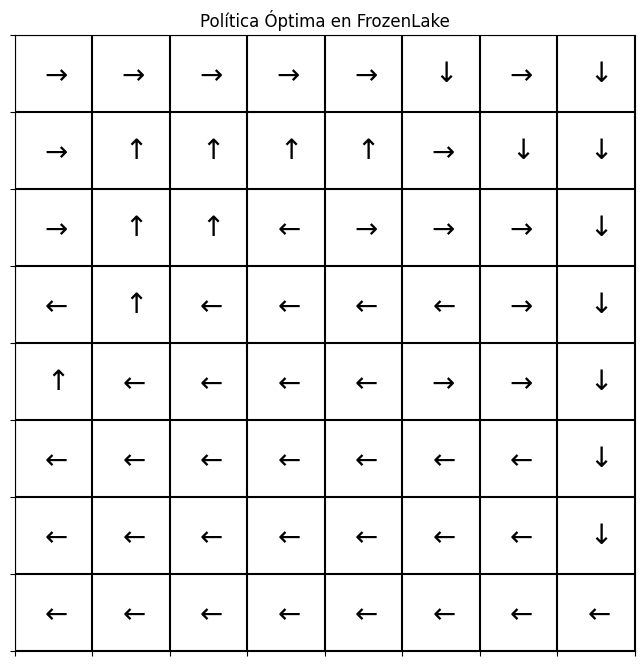

In [23]:
plot_policy_on_grid(Q, grid_size=(8,8))

In [24]:
# @title Política final
LEFT, DOWN, RIGHT, UP = 0,1,2,3
pi, actions = pi_star_from_Q(env8, Q)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env8.render())
print()

Política óptima obtenida
 [[0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 2. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 
 Acciones 2,

## **4. Análisis y Estudios Futuros**

### **4.1 Análisis de Resultados**

- En los dos entornos (4x4 y 8x8), el agente comienza con un conocimiento muy limitado, pero gradualmente mejora su desempeño a medida que avanza en los episodios. Este comportamiento se puede observar en el gráfico de la proporción de recompensas, que aumenta con el tiempo.
- En el entorno 4x4, la máxima proporción de éxito alcanzada fue 0.522, mientras que en el entorno 8x8, la máxima alcanzada fue 0.914. Esto refleja que el agente aprendió a optimizar su estrategia en un entorno más complejo.
- La política óptima obtenida muestra las acciones recomendadas por el agente en cada estado del entorno. En el entorno 8x8, la política es más compleja debido a la mayor cantidad de estados y la dificultad del entorno.

### **4.2 Propuestas para Estudios Futuros**

1. **Evaluar con Otros Entornos**: Sería interesante aplicar este algoritmo a otros entornos más complejos de `gym`, como "Taxi-v3" o "MountainCar", para analizar cómo se comporta el agente en situaciones con dinámicas más complicadas.
   
2. **Optimización del Decaimiento de Epsilon**: Aunque se utilizó un decaimiento de epsilon en el segundo experimento, se podría investigar la efectividad de diferentes tasas de decaimiento o incluso explorar algoritmos como `Q-learning` para comparar su desempeño. Graficamente se trataría de mostrar la curva de la tasa de aciertos para distintas funciones de decaimientos

3. **Análisis del Impacto de los descuentos en las Recompensas**: El estudio se ha hecho para $\gamma = 1$; pero no se ha probado qué pasa cuando  $0 \leq \gamma < 1$. Se trataría de estudiar la curva para distintos valores de $\gamma$

4. **Nuevas gráficas**: Aquí solo se ha usado la proporción de aciertos, pero sería interesante qué relación entre dicha tasa y las tamaños de los episodios.

4. **Ampliación del Algoritmo**: Explorar otros enfoques de Monte Carlo o incluso combinar Monte Carlo con otros algoritmos de aprendizaje por refuerzo, como el Deep Q-Network (DQN), podría mejorar aún más los resultados en entornos más complejos.


# Simulacion por video

In [25]:
#Repetimos para 8x8
video_dir_8x8 = record_policy_in_frozenlake(Q, map_name="8x8", episodes=2, video_folder="videos8x8", is_slippery=False)

latest_file_8x8 = get_latest_episode_video_file(video_dir_8x8)
print("Último video 8x8:", latest_file_8x8)
embed_video(latest_file_8x8)


/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos8x8 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Último video 8x8: videos8x8/rl-video-episode-1.mp4


#¿Por qué la longitud del episodio también es un buen indicador de aprendizaje?
En FrozenLake, un episodio termina cuando:

- El agente alcanza el objetivo, es decir recibe la recompensa positiva.
- El agente cae en un agujero, es decir el agente fallo y  como consecuencia sin recompensa.
- Se acaba el número máximo de pasos permitido.

Y cuando el agente aprende una buena política?

Normalmente encuentra la meta más rápidamente, por lo que el episodio se hace más corto y obtiene la recompensa deseada. Suele evitar perder tiempo en movimientos innecesarios o caer en agujeros de manera repetida.Por ello, ver que la longitud del episodio disminuye (mientras la proporción de aciertos aumenta) suele indicar que el agente no solo está alcanzando la meta, sino que lo hace con menos pasos, lo cual es señal de un comportamiento más eficiente.

En otras palabras, si el agente cada vez necesita menos acciones para lograr la recompensa final, quiere decir que está aprendiendo a navegar el entorno de manera óptima o cuasi-óptima. Por eso, el número de pasos en cada episodio se considera un buen indicador del grado de aprendizaje, complementario a la mera tasa de aciertos.